# ------- Предсказание дефолта по кредиту -------
Задача: Оценить риск невозврата кредита.

Датасет Bank 2007 to 2018.csv содержит информацию об одобренных кредитах за период с 2007 по 2018 год. В признаке loan_status содержится информация об оплате долга по кредиту.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Чтение нашего датасета 
df = pd.read_csv('Bank 2007 to 2018.csv')

# Вывод информации о датасете (df)
print(f'df head:\n {df.head(10)}')
print()
print(f'ds info:\n {df.info()}')

df head:
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   
5  68426831        NaN    11950.0      11950.0          11950.0   36 months   
6  68476668        NaN    20000.0      20000.0          20000.0   36 months   
7  67275481        NaN    20000.0      20000.0          20000.0   36 months   
8  68466926        NaN    10000.0      10000.0          10000.0   36 months   
9  68616873        NaN     8000.0       8000.0           8000.0   36 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4

In [3]:
df['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

1. **Fully Paid** (Полностью оплачено): Сумма кредитов, которые были полностью погашены заемщиками.
2. **Current** (Текущий): Сумма кредитов, которые находятся в текущем состоянии, то есть заемщики делают платежи вовремя и не имеют просрочек.
3. **Charged Off** (Списано): Сумма кредитов, которые были списаны как безнадежные к взысканию. Это означает, что кредитор считает, что заемщик не сможет вернуть долг.
4. **Late (31-120 days)** (Просрочка 31-120 дней): Сумма кредитов, по которым платежи задерживаются на срок от 31 до 120 дней.
5. **In Grace Period** (В льготный период): Сумма кредитов, которые находятся в льготном периоде, когда заемщики могут сделать платежи без штрафов.
6. **Late (16-30 days)** (Просрочка 16-30 дней): Сумма кредитов, по которым платежи задерживаются на срок от 16 до 30 дней.
7. **Does not meet the credit policy. Status: Fully Paid** (Не соответствует кредитной политике. Статус: Полностью оплачено): Сумма кредитов, которые были полностью оплачены, но не соответствуют определенным критериям кредитной политики.
8. **Does not meet the credit policy. Status: Charged Off** (Не соответствует кредитной политике. Статус: Списано): Сумма кредитов, которые были списаны, но также не соответствуют критериям кредитной политики.
9. **Default (Дефолт)**: Сумма кредитов, по которым заемщики не выполнили свои обязательства по платежам и находятся в состоянии дефолта.

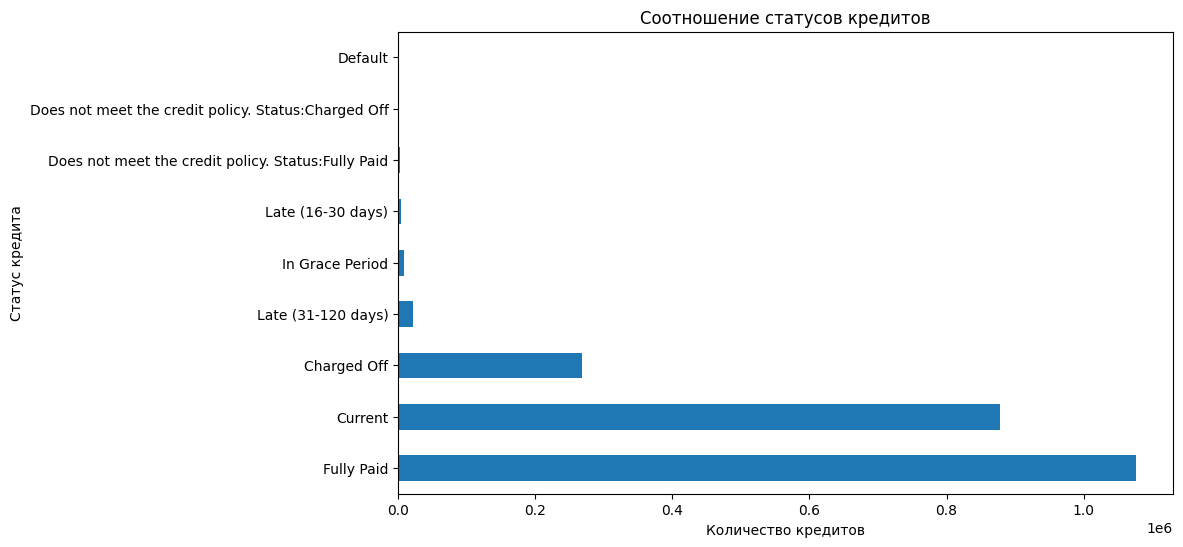

In [4]:
# Визуализация распределения целевого признака loan_status
plt.figure(figsize=(10, 6))
df['loan_status'].value_counts().plot(kind='barh')
plt.title("Соотношение статусов кредитов")
plt.xlabel("Количество кредитов")
plt.ylabel("Статус кредита")
plt.show()

In [5]:
# Мы удалим все ненужные параметры кроме интересующих: "Fully Paid" и "Charged Off"
target_loan= ["Fully Paid", "Charged Off"]

df = df[df["loan_status"].isin(target_loan)]

# Проверка оставшихся результатов
print(df['loan_status'].value_counts())

loan_status
Fully Paid     1076751
Charged Off     268559
Name: count, dtype: int64


<Axes: xlabel='loan_status', ylabel='count'>

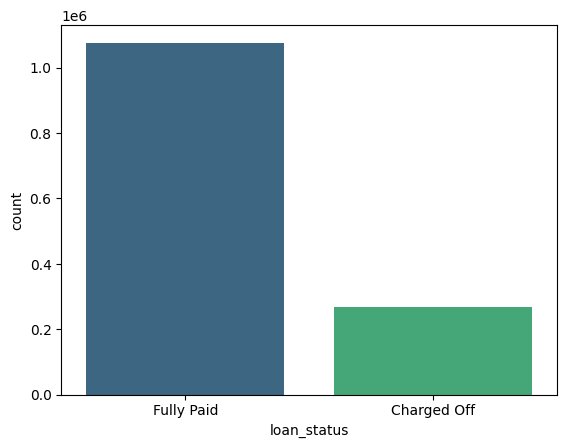

In [6]:
# Визуализация выбранных значений:
sns.countplot(x="loan_status", data=df, palette='viridis')

### Очистка данных

Найдем % нулевых значений, для каждого столбца и построим % пропущенных значений.

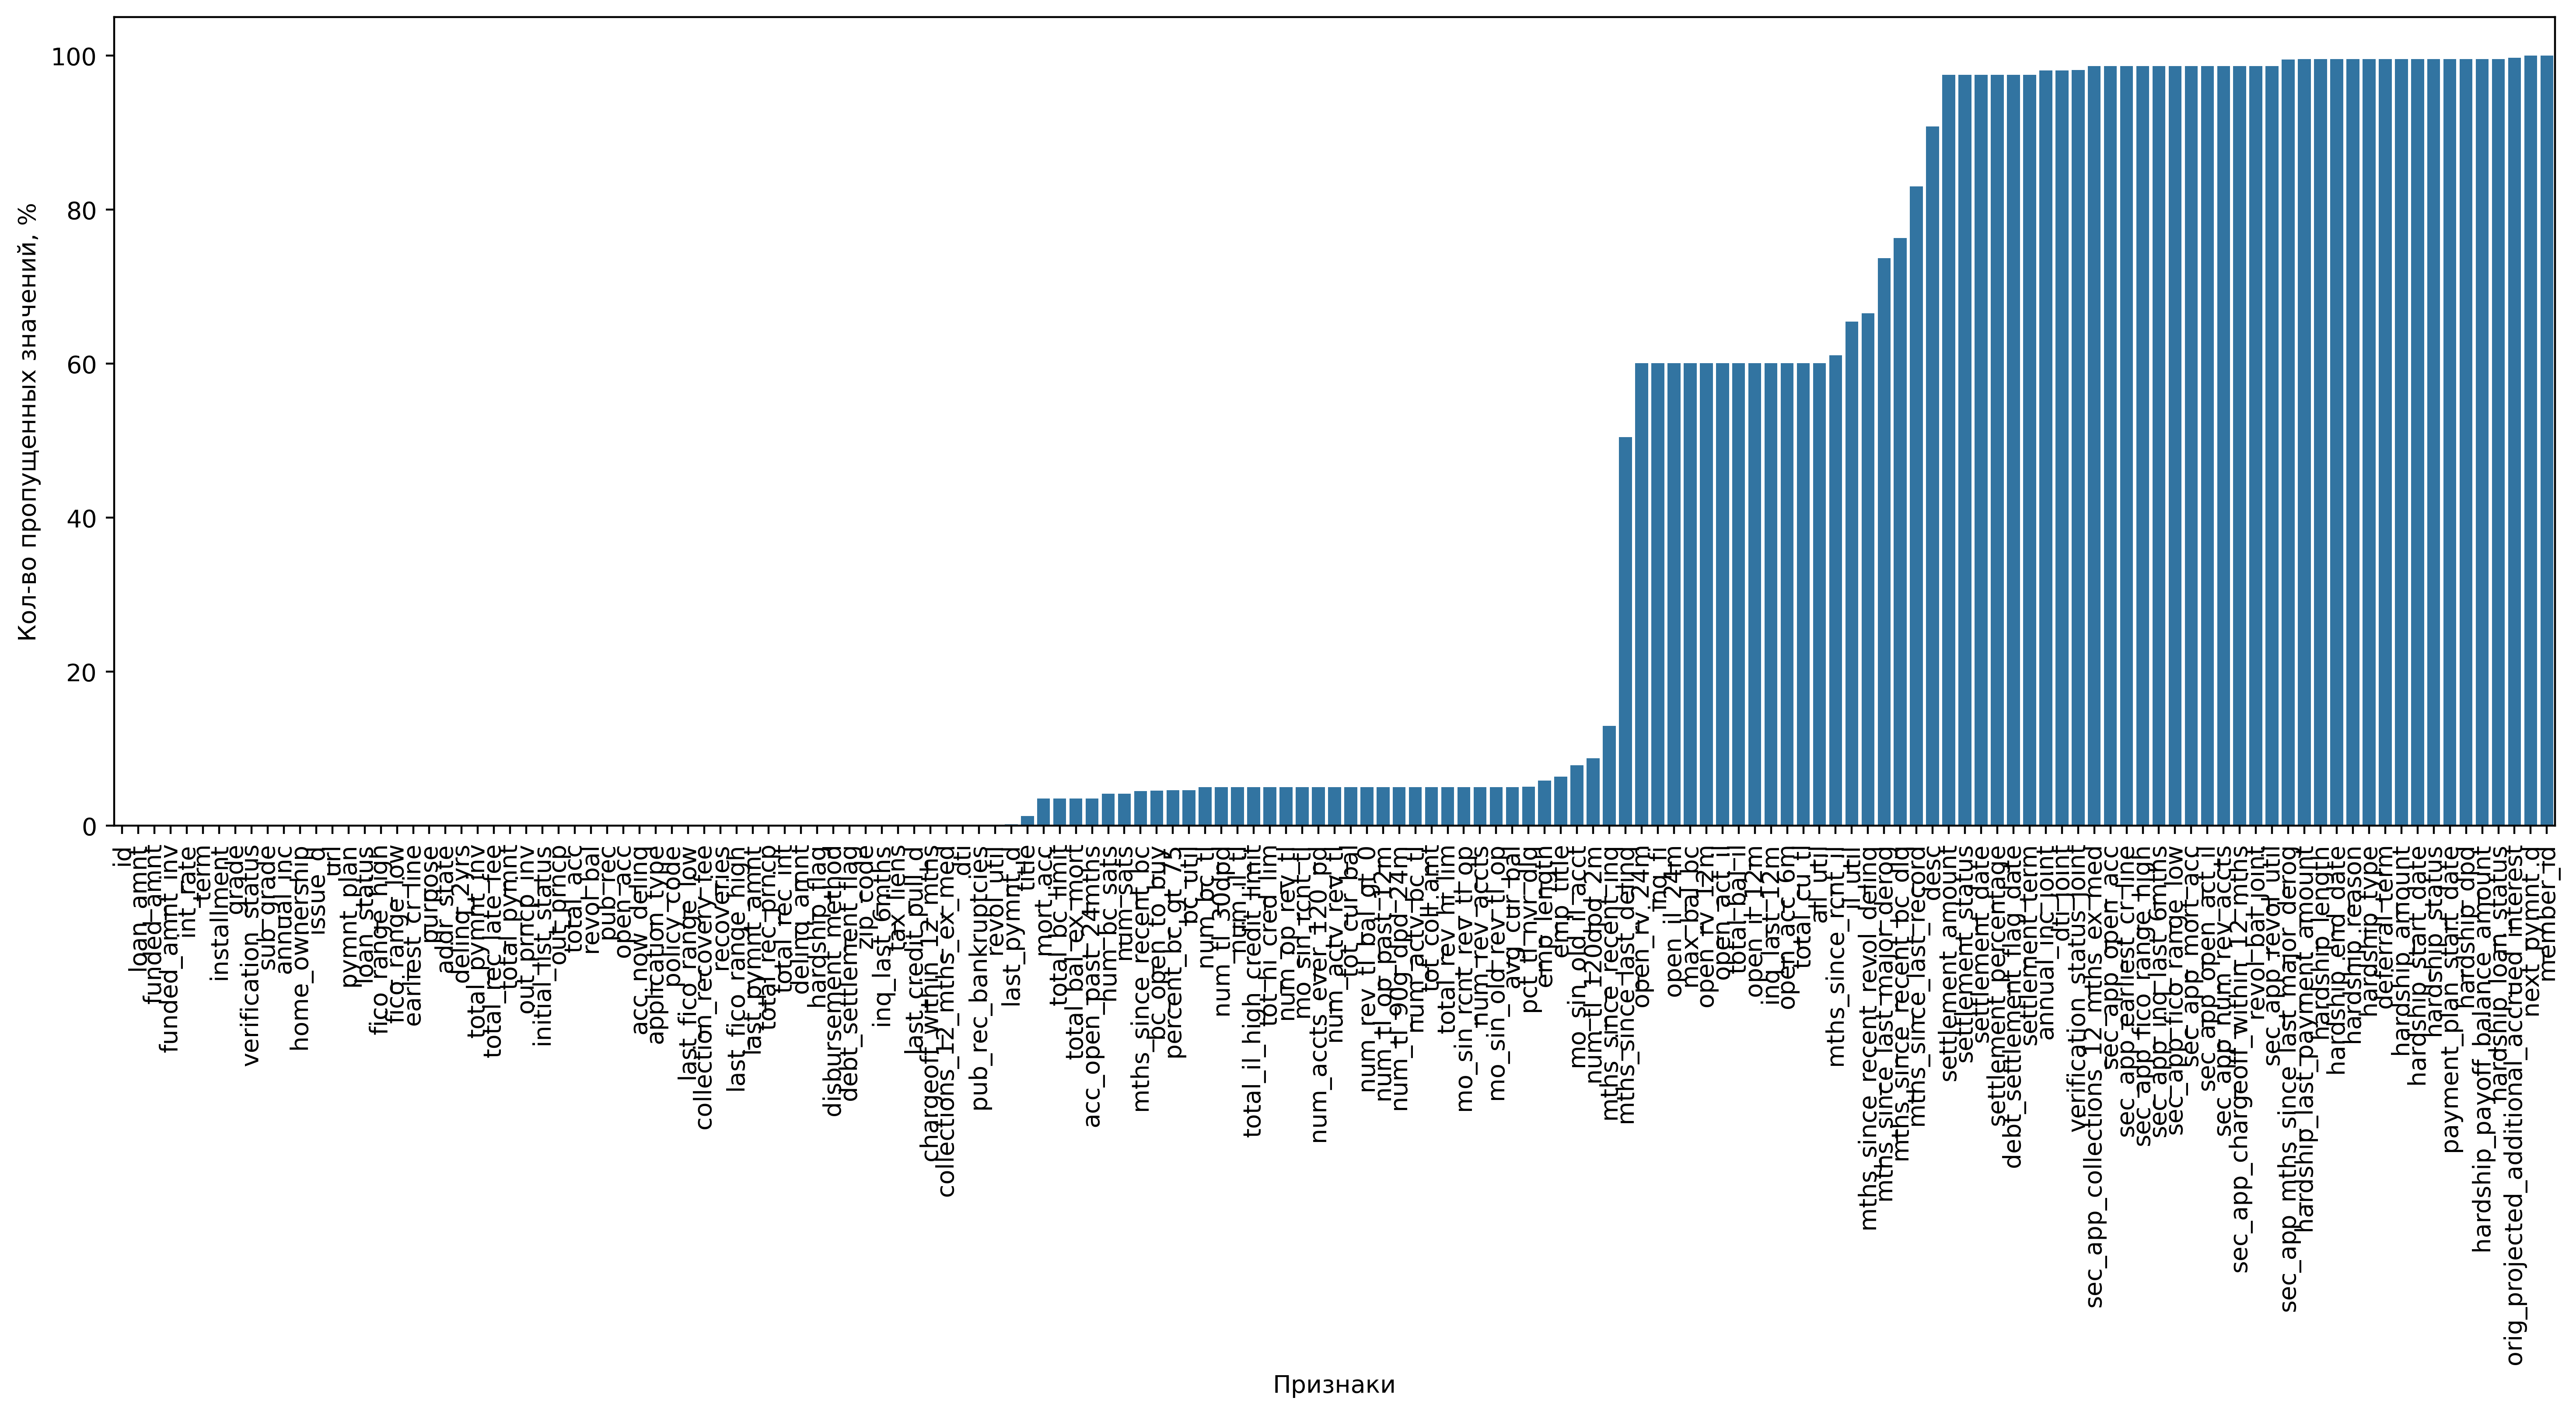

In [7]:
row_proc = ((df.isnull().sum() / len(df)) * 100)

# Задаем размер изображения и качетсво
plt.figure(figsize=(18,6), dpi=400)

# Визуализация
sns.barplot(y = row_proc.sort_values(), x = row_proc.sort_values().index) 
plt.xlabel('Признаки')
plt.ylabel('Кол-во пропущенных значений, %')
# Перевернем метки по оси ох с горизонтального положения на вертикальное
plt.xticks(rotation=90)
plt.show()

In [8]:
'''
Как видно много признаков имеет довольное больше колличество значений в % соотношении, 
поэтому оставим только данные у которых менее 30% пропущенных значений.
Поэтому уберем все признакми с большим колличество пропусков, а именно тех, что больше 30%.

'''
keep = df.columns[((df.isnull().sum() / len(df)) * 100 < 30)].to_list()
print(keep)
print(f'\nКолличесво оставшихся признаков: {len(keep)}')

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct

In [9]:
'''
Все равно, количество оставшихся признаков велико, продолжем их уменьшать:

'''
# Присвоим новые значения нашему df, пропуски которых меньше 30%
df = df[keep]


# Из данных признакво выберем более информативные
essential_features = [
    # Целевая пременная
    "loan_status",
    
    # Кредитные характеристики
    'fico_range_low',  # Наиболее важный (текущий кредитный рейтинг)
    'dti',             # Debt-to-Income ratio
    'revol_util',      # Использование кредитного лимита
    'open_acc',        # Открытые кредитные линии
    'total_acc',       # Всего кредитных счетов
    'pub_rec_bankruptcies', # Банкротства
    
    # Финансовые показатели
    'annual_inc',      # Годовой доход
    'loan_amnt',       # Запрашиваемая сумма
    'installment',     # Платеж по кредиту
    
    # Занятость и стаж
    'emp_length',      # Стаж работы
    
    # Демография и собственность
    'home_ownership',  # Тип жилья (OWN, RENT, MORTGAGE)
    
    # Условия кредита
    'term',            # Срок кредита
    'int_rate',        # Процентная ставка
    
    # Цель кредита (закодированная через One-Hot)
    "purpose",
    
    # Дополнительные проверки
    'mort_acc',           # Ипотечные счета
    'delinq_2yrs',        # Просрочки за 2 года
    'inq_last_6mths',     # Кредитные запросы
    'verification_status' # Подтвержден ли доход
]

df = df[essential_features]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1345310 entries, 0 to 2260697
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_status           1345310 non-null  object 
 1   fico_range_low        1345310 non-null  float64
 2   dti                   1344936 non-null  float64
 3   revol_util            1344453 non-null  float64
 4   open_acc              1345310 non-null  float64
 5   total_acc             1345310 non-null  float64
 6   pub_rec_bankruptcies  1344613 non-null  float64
 7   annual_inc            1345310 non-null  float64
 8   loan_amnt             1345310 non-null  float64
 9   installment           1345310 non-null  float64
 10  emp_length            1266799 non-null  object 
 11  home_ownership        1345310 non-null  object 
 12  term                  1345310 non-null  object 
 13  int_rate              1345310 non-null  float64
 14  purpose               1345310 non-null 

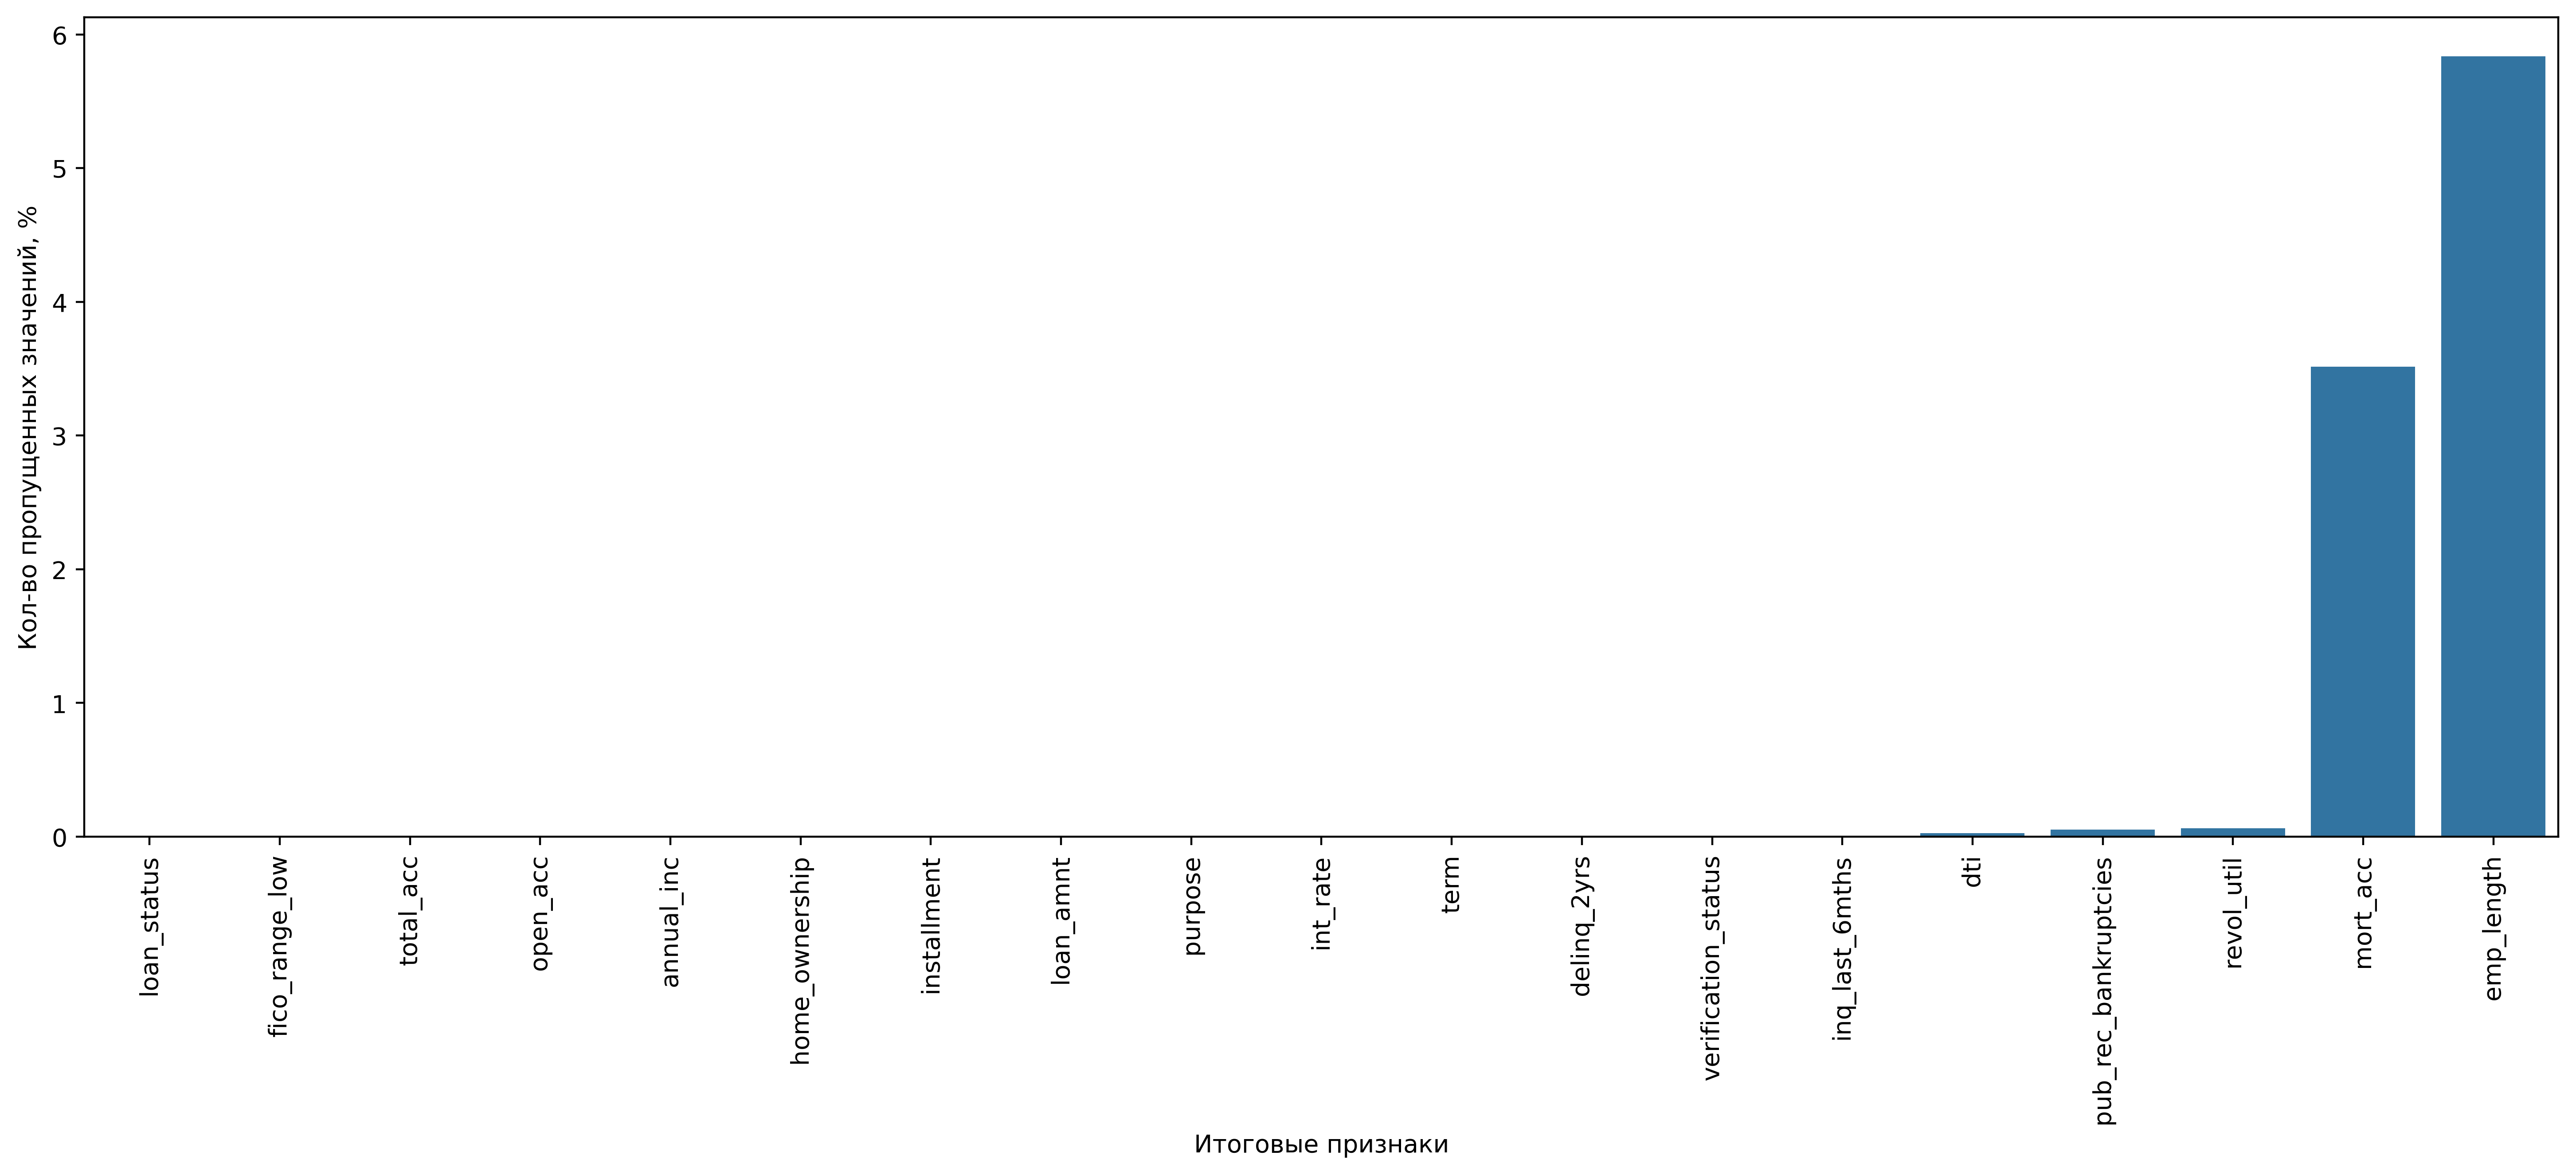

In [10]:
# Обновим информацию по пропущенным данным, для наших итоговых признаков
row_proc = ((df.isnull().sum() / len(df)) * 100)

# Задаем размер изображения и качетсво
plt.figure(figsize=(18, 6), dpi=400)

# Визуализация
sns.barplot(y = row_proc.sort_values(), x = row_proc.sort_values().index) 
plt.xlabel('Итоговые признаки')
plt.ylabel('Кол-во пропущенных значений, %')
# Перевернем метки по оси ох с горизонтального положения на вертикальное
plt.xticks(rotation=90)
plt.show()

In [11]:
'''
По итогу у нас оставшиеся столбцы с пропусками имеют не более 6% пропусков от общего объема данных,
так как остался все равно массивный датафрейм, а именно значений у нас >1кк, поэтому удалим ряды, значения которых отсутствуют:

'''
# Удаляем пропуски
df = df.dropna()

# Вывод результата
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1220091 entries, 0 to 2260697
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_status           1220091 non-null  object 
 1   fico_range_low        1220091 non-null  float64
 2   dti                   1220091 non-null  float64
 3   revol_util            1220091 non-null  float64
 4   open_acc              1220091 non-null  float64
 5   total_acc             1220091 non-null  float64
 6   pub_rec_bankruptcies  1220091 non-null  float64
 7   annual_inc            1220091 non-null  float64
 8   loan_amnt             1220091 non-null  float64
 9   installment           1220091 non-null  float64
 10  emp_length            1220091 non-null  object 
 11  home_ownership        1220091 non-null  object 
 12  term                  1220091 non-null  object 
 13  int_rate              1220091 non-null  float64
 14  purpose               1220091 non-null 

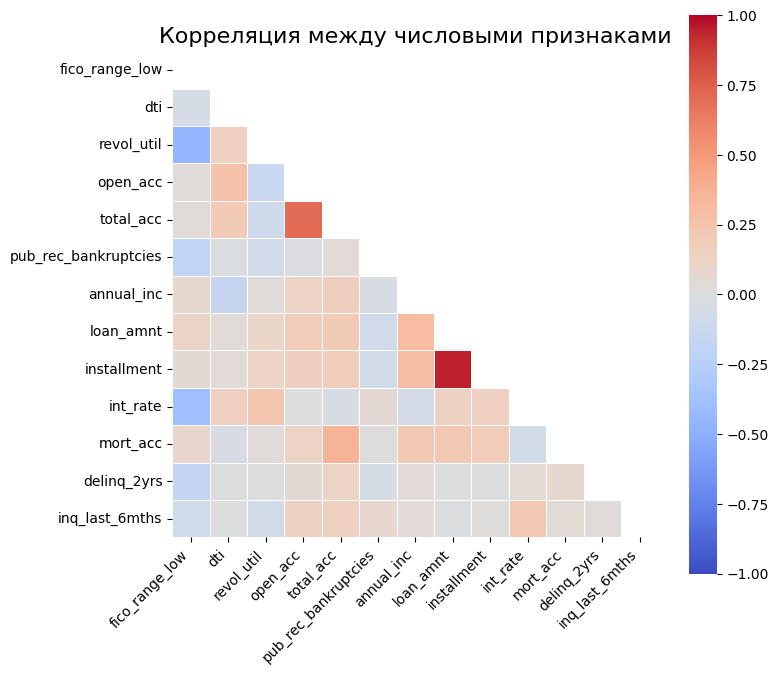

In [12]:
'''
Визуализируем корреляционную матрицу, для числовых признаков

'''
# 1. Выбираем только числовые колонки
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[numeric_cols]

# 2. Создаем маску для верхнего треугольника
plt.figure(figsize=(8, 7))
mask = np.zeros_like(df_numeric.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 3. Настраиваем тепловую карту
heatmap = sns.heatmap(df_numeric.corr(), 
                      mask=mask,
                      cmap='coolwarm', 
                      annot=False, 
                      square=True,
                      vmin=-1, vmax=1,
                      linewidths=0.5)

# 4. Добавляем заголовок и настраиваем отображение
plt.title('Корреляция между числовыми признаками', fontsize=16)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [13]:
''' Просмотрим на признаки, которые имеют высокую корреляцию'''

# Выбираем только числовые признаки
numeric_cols = df.select_dtypes(include=['number']).columns

# Создаем матрицу абсолютных значений корреляций
corr_matrix = df[numeric_cols].corr().abs()

# Преобразуем матрицу корреляций в пары признаков
corr_pairs = (
    corr_matrix.stack()                   # Переводим в "длинный" формат
    .reset_index()                        # Преобразуем в DataFrame
    .rename(columns={0: 'corr'})          # Переименовываем столбец с корреляциями
    .query("level_0 != level_1")          # Удаляем диагональные элементы (корреляция признака с самим собой)
    .sort_values('corr', ascending=False) # Сортируем по убыванию корреляции
    .drop_duplicates()                    # Удаляем дубликаты пар (A-B и B-A)
)

# Выбираем только сильно коррелированные пары (корреляция > 0.8)
high_corr_pairs = corr_pairs[corr_pairs['corr'] > 0.8]

# Выводим результат
print(f"Пары признаков с высокой корреляцией (>0.8):\n{high_corr_pairs}")

Пары признаков с высокой корреляцией (>0.8):
         level_0      level_1      corr
111  installment    loan_amnt  0.952998
99     loan_amnt  installment  0.952998


In [14]:
df = df.drop(columns=['installment'])  # Удаляем, так как он вычисляется из loan_amnt

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1220091 entries, 0 to 2260697
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_status           1220091 non-null  object 
 1   fico_range_low        1220091 non-null  float64
 2   dti                   1220091 non-null  float64
 3   revol_util            1220091 non-null  float64
 4   open_acc              1220091 non-null  float64
 5   total_acc             1220091 non-null  float64
 6   pub_rec_bankruptcies  1220091 non-null  float64
 7   annual_inc            1220091 non-null  float64
 8   loan_amnt             1220091 non-null  float64
 9   emp_length            1220091 non-null  object 
 10  home_ownership        1220091 non-null  object 
 11  term                  1220091 non-null  object 
 12  int_rate              1220091 non-null  float64
 13  purpose               1220091 non-null  object 
 14  mort_acc              1220091 non-null 

### Работа с категориальными переменными

In [15]:
'''
Преобразуем наши категориальные переменные

'''
print(df.select_dtypes(['object']).info())

<class 'pandas.core.frame.DataFrame'>
Index: 1220091 entries, 0 to 2260697
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   loan_status          1220091 non-null  object
 1   emp_length           1220091 non-null  object
 2   home_ownership       1220091 non-null  object
 3   term                 1220091 non-null  object
 4   purpose              1220091 non-null  object
 5   verification_status  1220091 non-null  object
dtypes: object(6)
memory usage: 65.2+ MB
None


In [16]:
print(df.loan_status.value_counts())
print(df.emp_length.value_counts())
print(df.home_ownership.value_counts())
print(df.term.value_counts())
print(df.purpose.value_counts())
print(df.verification_status.value_counts())

loan_status
Fully Paid     979418
Charged Off    240673
Name: count, dtype: int64
emp_length
10+ years    431105
2 years      116571
3 years      102817
< 1 year     102716
1 year        84645
5 years       80175
4 years       76432
6 years       59928
8 years       58904
7 years       57413
9 years       49385
Name: count, dtype: int64
home_ownership
MORTGAGE    608596
RENT        485441
OWN         125703
ANY            266
NONE            43
OTHER           42
Name: count, dtype: int64
term
36 months    919862
60 months    300229
Name: count, dtype: int64
purpose
debt_consolidation    715065
credit_card           270857
home_improvement       77907
other                  67852
major_purchase         25427
medical                13477
small_business         12835
car                    12072
moving                  8264
vacation                7969
house                   6367
wedding                 1231
renewable_energy         767
educational                1
Name: count, dtype: i

In [17]:
# Преобразуем переменные: 1 - Fully Paid, 0 - Charged Off 
df['loan_status'] = (df['loan_status'] == 'Fully Paid').astype('int8')
print(df['loan_status'].value_counts())

loan_status
1    979418
0    240673
Name: count, dtype: int64


In [18]:
# 2. Обработка emp_length (стаж работы)
# Удалим символы и преобразуем в числовой формат
df['emp_length'] = (
    df['emp_length']
    .str.replace('\+', '', regex=True)  # Удаляем "+" в "10+ years"
    .str.replace('< 1', '0', regex=True)  # Заменяем "< 1 year" на 0
    .str.replace(' years?', '', regex=True)  # Удаляем " year" или " years"
    .astype(float)  # Преобразуем в число
)

print(df['emp_length'].value_counts())

emp_length
10.0    431105
2.0     116571
3.0     102817
0.0     102716
1.0      84645
5.0      80175
4.0      76432
6.0      59928
8.0      58904
7.0      57413
9.0      49385
Name: count, dtype: int64


In [19]:
# Преобразуем признак home_ownership:
# Много лишних категорий, создадим список редких категорий
rare_categories = ['ANY', 'OTHER', 'NONE']

# Заменяем их на 'OTHER'
df['home_ownership'] = df['home_ownership'].replace(rare_categories, 'OTHER')

# Применяем One-Hot Encoding для home_ownership
df = pd.get_dummies(df, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)

In [20]:
# Преобразуем признака term
# Преобразуем переменные в числовые: 36 - 36 месяцев, 60 - 60 месяцев
l1 = df.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df['term'] = df['term'].map(d).astype('int8')
print(df['term'].value_counts())

term
36    919862
60    300229
Name: count, dtype: int64


In [21]:
# Применяем One-Hot Encoding для purpose и verification_status:
# Обработка purpose (цель кредита)
main_purposes = ['debt_consolidation', 'credit_card', 'home_improvement', 'other']
df['purpose'] = df['purpose'].where(
    df['purpose'].isin(main_purposes), 'other'
)
df = pd.get_dummies(df, columns=['purpose'], prefix='purpose', drop_first=True)


# Обработка verification_status (статус верификации)
# 1. Сначала преобразуем статусы в 2 бинарных признака:
df['Source_Verified'] = (df['verification_status'] == 'Source Verified').astype(bool)
df['Verified'] = (df['verification_status'] == 'Verified').astype(bool)

# 2. Удаляем исходный столбец:
df = df.drop('verification_status', axis=1)

In [22]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1220091 entries, 0 to 2260697
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_status                 1220091 non-null  int8   
 1   fico_range_low              1220091 non-null  float64
 2   dti                         1220091 non-null  float64
 3   revol_util                  1220091 non-null  float64
 4   open_acc                    1220091 non-null  float64
 5   total_acc                   1220091 non-null  float64
 6   pub_rec_bankruptcies        1220091 non-null  float64
 7   annual_inc                  1220091 non-null  float64
 8   loan_amnt                   1220091 non-null  float64
 9   emp_length                  1220091 non-null  float64
 10  term                        1220091 non-null  int8   
 11  int_rate                    1220091 non-null  float64
 12  mort_acc                    1220091 non-null  float64
 13  de

# Построение класических моделей

In [23]:
# Импорт нужной библиотеки
from sklearn.model_selection import train_test_split

df_copy = df.copy()

X = df_copy.loc[:, df_copy.columns != 'loan_status'].values
y = df_copy.loan_status.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Импорт нужной библиотеки
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(976072, 22)
(244019, 22)


## RandomForest

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Определяем гиперпараметры для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    
    # Создаем модель
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        bootstrap=True,
        n_jobs=-1
    )

    # Оценка с использованием кросс-валидации
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
    return score


# Создание объекта Study и запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

# Вывод лучших гиперпараметров
print("Best parameters found: ", study.best_params)

In [25]:
# Ипорт библиотек
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (  # Метрики качества
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# Обучение модели на заранее подобранных гиперпараметрах через optuna
rf = RandomForestClassifier(n_estimators= 311, random_state=42, max_depth=19, bootstrap=True, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Предсказание
y_pred = rf.predict(X_test_scaled)

# Оценка 
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest AUC-ROC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.8069412627705219
Random Forest AUC-ROC: 0.5246622542747696
              precision    recall  f1-score   support

           0       0.57      0.06      0.11     47816
           1       0.81      0.99      0.89    196203

    accuracy                           0.81    244019
   macro avg       0.69      0.52      0.50    244019
weighted avg       0.76      0.81      0.74    244019



<Axes: >

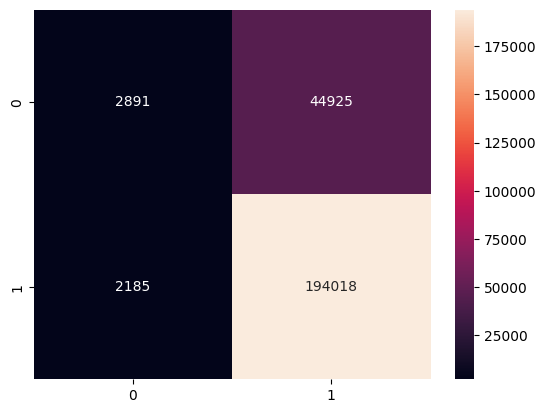

In [26]:
# Вывод матрицы ошибок для RandomForest
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

Нарисуем кривую AUC-ROC, которая показывает, как меняется соотношение True Positive Rate (Recall) и False Positive Rate при варьировании порога классификации.

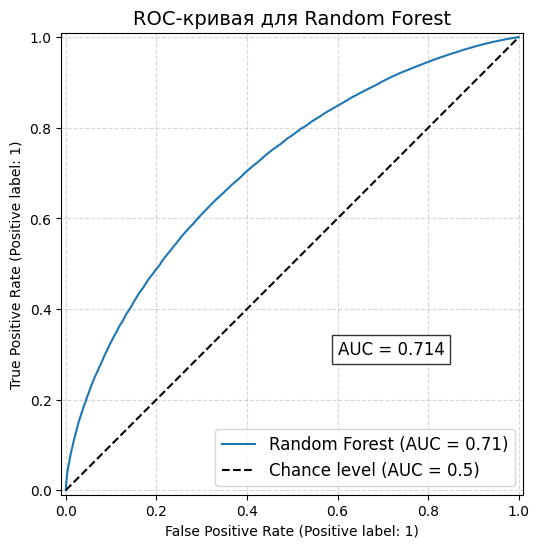

In [27]:
# Ипорт библиотек
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Получаем вероятности для положительного класса
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

# Строим ROC-кривую
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(
    rf, 
    X_test_scaled, 
    y_test,
    name='Random Forest',
    ax=ax,
    plot_chance_level=True  # Добавляем диагональ случайного угадывания
)

# Добавляем аннотацию с AUC
plt.text(0.6, 0.3, f'AUC = {roc_auc_score(y_test, y_proba):.3f}',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Настройки оформления
plt.title('ROC-кривая для Random Forest', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.show()

## GradientBoosting

In [ ]:
# Ипорт библиотек
import optuna
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Определяем гиперпараметры для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    
    # Создаем модель
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )
    
    # Оценка с использованием кросс-валидации
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
    return score
    
# Создание объекта Study и запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

# Вывод лучших гиперпараметров
print("Best parameters found: ", study.best_params)

In [28]:
# Ипорт библиотек
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report)

# Обучение модели на заранее подобранных гиперпараметрах через optuna
gb = GradientBoostingClassifier(n_estimators=233, max_depth=5, learning_rate=0.033, random_state=42)
gb.fit(X_train_scaled, y_train)

# Предсказание
y_pred = gb.predict(X_test_scaled)

# Оценка
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred))
print("Gradient Boosting AUC-ROC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Gradient Boosting Accuracy: 0.8068306156487814
Gradient Boosting AUC-ROC: 0.52725856863185
              precision    recall  f1-score   support

           0       0.56      0.07      0.12     47816
           1       0.81      0.99      0.89    196203

    accuracy                           0.81    244019
   macro avg       0.69      0.53      0.51    244019
weighted avg       0.76      0.81      0.74    244019



In [29]:
import joblib

# Сохранение модели и скейлера
joblib.dump(gb, "gb.joblib")
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

<Axes: >

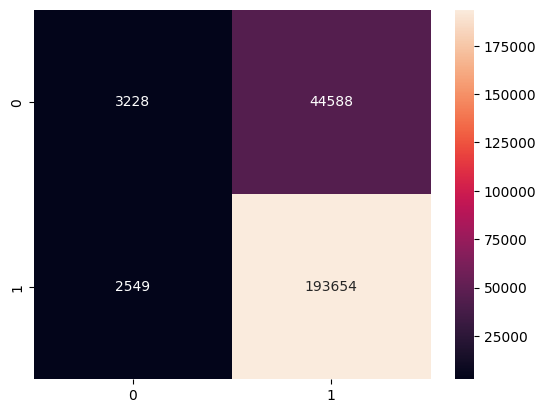

In [30]:
# Вывод матрицы ошибок
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

## Catboost

In [31]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, roc_auc_score

# Создаем Pool для CatBoost
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Параметры модели с учетом дисбаланса
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    eval_metric='F1',
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),  # Автобалансировка
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
)

# Обучение
model.fit(train_pool, eval_set=test_pool)

# Предсказания
y_pred = model.predict(test_pool)
y_proba = model.predict_proba(test_pool)[:, 1]

# Оценка
print("Catboost Accuracy:", accuracy_score(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred))

0:	learn: 0.6437078	test: 0.6433564	best: 0.6433564 (0)	total: 280ms	remaining: 4m 39s
100:	learn: 0.6498955	test: 0.6489699	best: 0.6489699 (100)	total: 13.6s	remaining: 2m
200:	learn: 0.6545554	test: 0.6520064	best: 0.6520064 (200)	total: 26.7s	remaining: 1m 46s
300:	learn: 0.6575996	test: 0.6534930	best: 0.6535356 (299)	total: 39.8s	remaining: 1m 32s
400:	learn: 0.6600700	test: 0.6544064	best: 0.6544930 (399)	total: 52.5s	remaining: 1m 18s
500:	learn: 0.6620210	test: 0.6552390	best: 0.6552877 (499)	total: 1m 5s	remaining: 1m 5s
600:	learn: 0.6637971	test: 0.6555907	best: 0.6557215 (572)	total: 1m 18s	remaining: 51.9s
700:	learn: 0.6652003	test: 0.6562003	best: 0.6563116 (693)	total: 1m 31s	remaining: 38.8s
800:	learn: 0.6667950	test: 0.6565436	best: 0.6565436 (800)	total: 1m 43s	remaining: 25.8s
900:	learn: 0.6682581	test: 0.6568865	best: 0.6569060 (868)	total: 1m 56s	remaining: 12.8s
999:	learn: 0.6695448	test: 0.6569822	best: 0.6571701 (984)	total: 2m 9s	remaining: 0us

bestTest =

<Axes: >

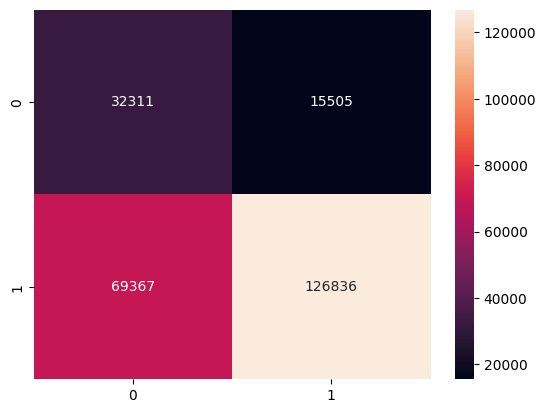

In [32]:
# Вывод матрицы ошибок
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

In [ ]:
df_copy.to_csv('credit_data.csv', index=False)

In [52]:
df.loan_status.value_counts()

loan_status
1    979418
0    240673
Name: count, dtype: int64

In [ ]:
ва

# Построение искуственной нейронной сети (ИНС)

In [33]:
# Импорт нужной библиотеки
from sklearn.model_selection import train_test_split

df_copy = df.copy()

y = df_copy["loan_status"]
X = df_copy.drop(['loan_status'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)

(1098081, 22)
(122010, 22)


Using device: cpu
Epoch 1/200
Train Loss: 0.7171 | Val Loss: 0.6981
Val Accuracy: 0.2323
--------------------------------------------------
Epoch 6/200
Train Loss: 0.5779 | Val Loss: 0.6872
Val Accuracy: 0.6338
--------------------------------------------------
Epoch 11/200
Train Loss: 0.5013 | Val Loss: 0.6448
Val Accuracy: 0.8014
--------------------------------------------------
Epoch 16/200
Train Loss: 0.4722 | Val Loss: 0.5843
Val Accuracy: 0.8051
--------------------------------------------------
Epoch 21/200
Train Loss: 0.4662 | Val Loss: 0.5308
Val Accuracy: 0.8051
--------------------------------------------------
Epoch 26/200
Train Loss: 0.4650 | Val Loss: 0.4977
Val Accuracy: 0.8051
--------------------------------------------------
Epoch 31/200
Train Loss: 0.4630 | Val Loss: 0.4800
Val Accuracy: 0.8051
--------------------------------------------------
Epoch 36/200
Train Loss: 0.4608 | Val Loss: 0.4700
Val Accuracy: 0.8052
--------------------------------------------------


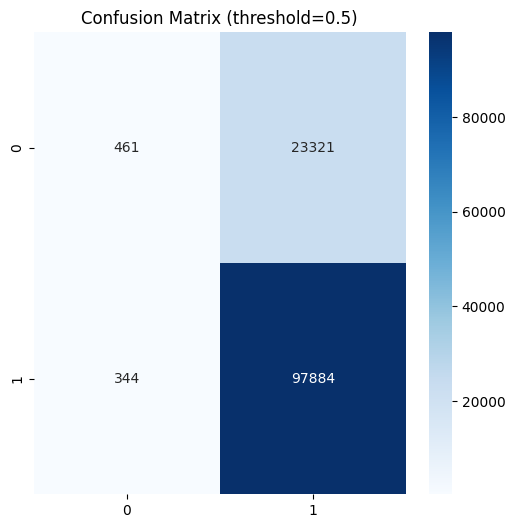


Evaluation for threshold = 0.7:
              precision    recall  f1-score   support

         0.0       0.38      0.38      0.38     23782
         1.0       0.85      0.85      0.85     98228

    accuracy                           0.76    122010
   macro avg       0.62      0.62      0.62    122010
weighted avg       0.76      0.76      0.76    122010



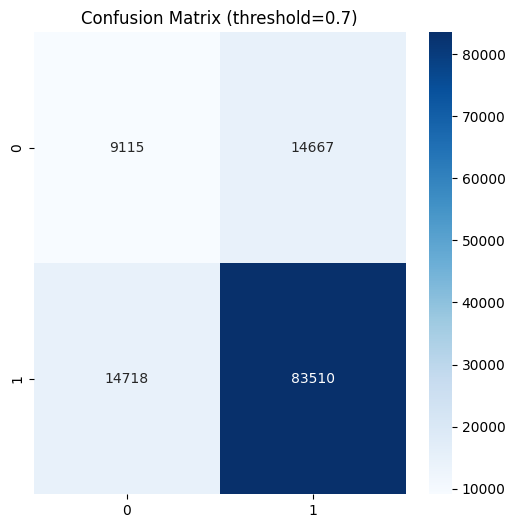


Evaluation for threshold = 0.75:
              precision    recall  f1-score   support

         0.0       0.34      0.52      0.41     23782
         1.0       0.87      0.76      0.81     98228

    accuracy                           0.71    122010
   macro avg       0.61      0.64      0.61    122010
weighted avg       0.77      0.71      0.73    122010



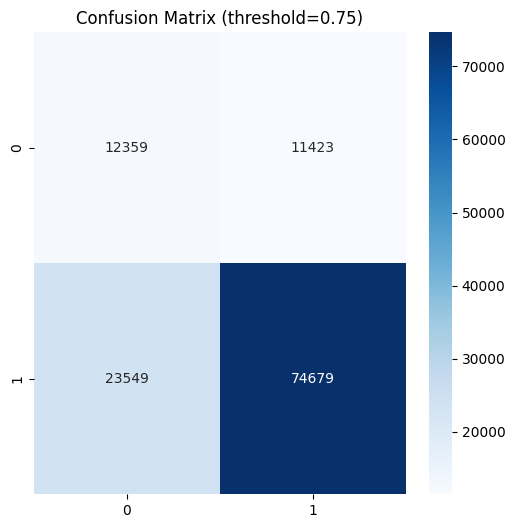


Evaluation for threshold = 0.8:
              precision    recall  f1-score   support

         0.0       0.30      0.68      0.42     23782
         1.0       0.89      0.63      0.73     98228

    accuracy                           0.64    122010
   macro avg       0.60      0.65      0.58    122010
weighted avg       0.77      0.64      0.67    122010



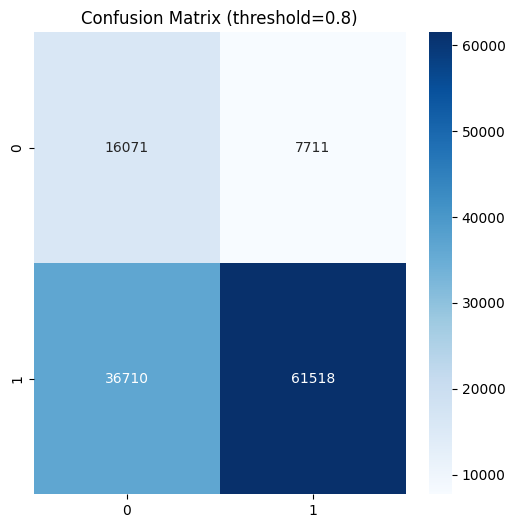


Evaluation for threshold = 0.85:
              precision    recall  f1-score   support

         0.0       0.27      0.82      0.40     23782
         1.0       0.91      0.45      0.60     98228

    accuracy                           0.52    122010
   macro avg       0.59      0.63      0.50    122010
weighted avg       0.79      0.52      0.56    122010



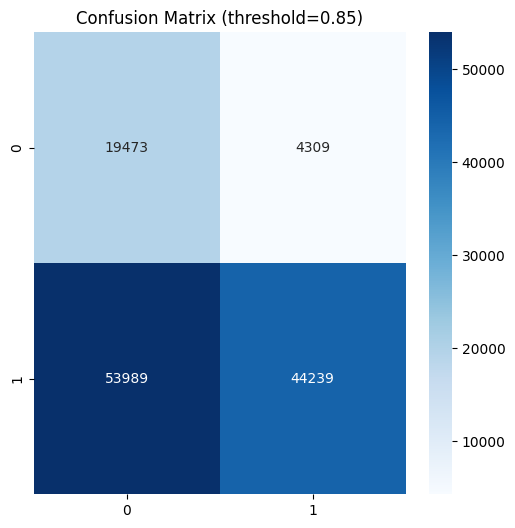


Analyzing feature importance...

All features with importance scores:
 1. fico_range_low                 | Importance: 0.1212
 2. dti                            | Importance: 0.1170
 3. revol_util                     | Importance: 0.1132
 4. open_acc                       | Importance: 0.1123
 5. total_acc                      | Importance: 0.1036
 6. pub_rec_bankruptcies           | Importance: 0.1093
 7. annual_inc                     | Importance: 0.1085
 8. loan_amnt                      | Importance: 0.1047
 9. emp_length                     | Importance: 0.1044
10. term                           | Importance: 0.1026
11. int_rate                       | Importance: 0.1261
12. mort_acc                       | Importance: 0.1089
13. delinq_2yrs                    | Importance: 0.1030
14. inq_last_6mths                 | Importance: 0.1019
15. OTHER                          | Importance: 0.1065
16. OWN                            | Importance: 0.0957
17. RENT                         

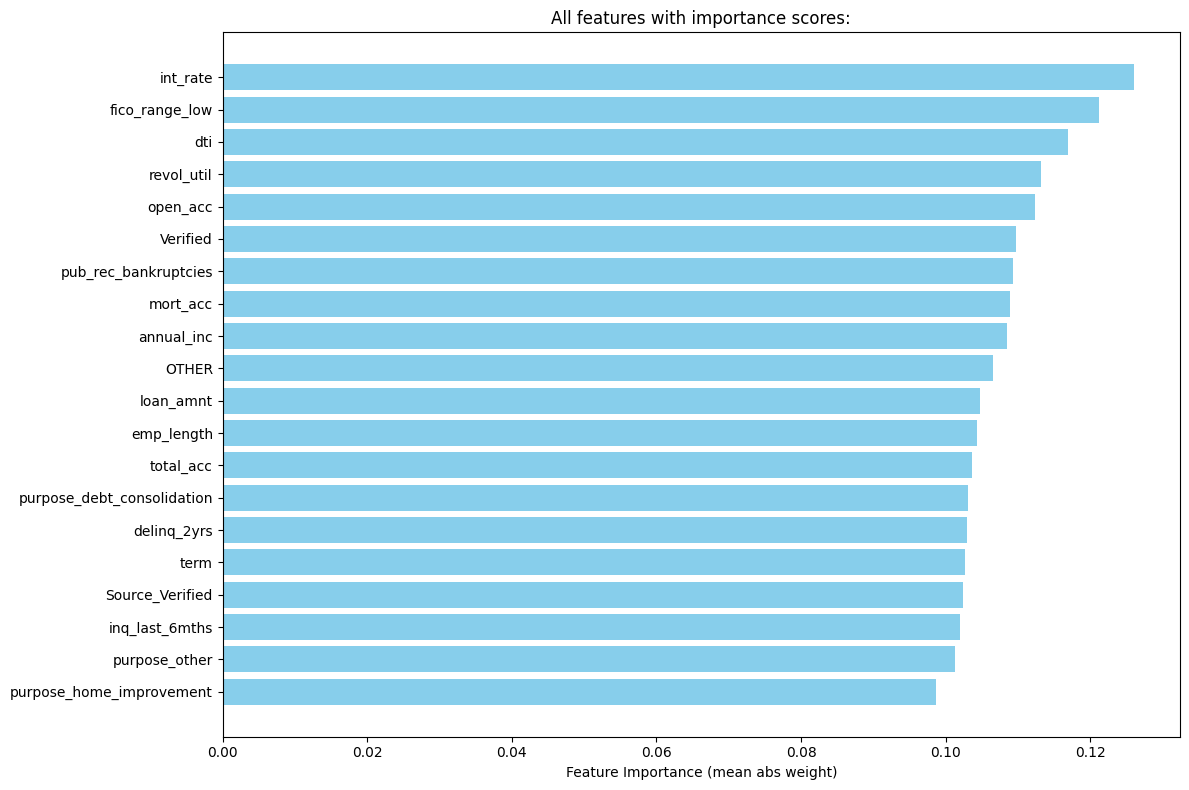


All models and artifacts saved to: C:\Users\ACER\IT-ac Project\saved_model


In [34]:
# Импорт библиотек
import torch
import torch.nn as nn    
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# ==================== НАСТРОЙКА УСТРОЙСТВА ====================
# Проверяем доступность GPU для ускорения вычислений
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# ==================== АРХИТЕКТУРА МОДЕЛИ ====================
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Последовательная архитектура сети
        self.layers = nn.Sequential(
            # Первый скрытый слой
            nn.Linear(input_size, 256),
            nn.ReLU(),                     # Функция активации
            nn.BatchNorm1d(256),           # Нормализация данных
            nn.Dropout(0.4),               # Регуляризация - отключаем 40% нейронов
            
            # Второй скрытый слой
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            # Третий скрытый слой
            nn.Linear(128, 64),
            nn.ReLU(),
            
            # Выходной слой
            nn.Linear(64, 1),
            nn.Sigmoid()                    # Преобразует выход в вероятность [0,1]
        )
    
    def forward(self, x):
        # Прямой проход данных через сеть
        return self.layers(x)


# ==================== ПОДГОТОВКА ДАННЫХ ====================
# Создаем директорию для сохранения артефактов модели
model_dir = Path("saved_model")
model_dir.mkdir(exist_ok=True)

# Сохраняем названия признаков до масштабирования
feature_names = X_train.columns.tolist()

# Масштабирование данных (приведение к диапазону [0, 1])
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)     # Обучение scaler и трансформация тренировочных данных
X_test_scaled = scaler.transform(X_test)           # Трансформация тестовых данных

# Сохраняем scaler и названия признаков для последующего использования
joblib.dump(scaler, model_dir/'scaler.pkl')
with open(model_dir/'feature_names.json', 'w') as f:
    json.dump(feature_names, f)

# Преобразование данных в тензоры PyTorch и перенос на выбранное устройство
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1).to(device)


# ==================== ИНИЦИАЛИЗАЦИЯ МОДЕЛИ ====================
input_size = X_train.shape[1]                            # Количество входных признаков
model = NeuralNetwork(input_size=input_size).to(device)  # Создаем экземпляр модели
optimizer = optim.AdamW(model.parameters(), lr=0.001)    # Оптимизатор с весомым распадом
criterion = nn.BCELoss()                                 # Функция потерь для бинарной классификации


# ==================== НАСТРОЙКИ ОБУЧЕНИЯ ====================
patience = 10                      # Количество эпох без улучшений перед ранней остановкой
early_stopping_counter = 0
best_loss = float('inf')           # Инициализация лучшего значения потерь

# Инициализация списков для хранения истории метрик
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Словарь для хранения лучших моделей по разным порогам
best_metrics = {
    0.5: {'f1': 0, 'threshold': 0.5, 'model_state': None},
    0.7: {'f1': 0, 'threshold': 0.7, 'model_state': None},
    0.75: {'f1': 0, 'threshold': 0.75, 'model_state': None},
    0.8: {'f1': 0, 'threshold': 0.8, 'model_state': None},
    0.85: {'f1': 0, 'threshold': 0.85, 'model_state': None}
}


# ==================== ЦИКЛ ОБУЧЕНИЯ ====================
for epoch in range(200):
    # Режим обучения
    model.train()
    optimizer.zero_grad()     # Обнуляем градиенты
    
    # Прямой проход
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Обратный проход и оптимизация
    loss.backward()
    optimizer.step()
    
    # ============ ВАЛИДАЦИЯ ============
    model.eval()  # Режим оценки
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_probs = val_outputs.cpu().numpy().flatten()
        y_test_np = y_test_tensor.cpu().numpy().flatten()
        
        # Вычисляем accuracy для мониторинга
        val_preds = (val_probs > 0.5).astype(int)
        val_acc = accuracy_score(y_test_np, val_preds)
        
        # Проверяем метрики для каждого порога классификации
        for threshold in best_metrics.keys():
            val_preds = (val_probs > threshold).astype(int)
            current_f1 = f1_score(y_test_np, val_preds)
            
            # Сохраняем лучшие веса модели
            if current_f1 > best_metrics[threshold]['f1']:
                best_metrics[threshold]['f1'] = current_f1
                best_metrics[threshold]['model_state'] = model.state_dict()
    
    # Вывод информации о процессе обучения
    if (epoch) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{200}")
        print(f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
        print(f"Val Accuracy: {val_acc:.4f}")
        print("-" * 50)
    
    # Сохранение метрик для графиков
    train_loss_history.append(loss.item())
    val_loss_history.append(val_loss.item())
    train_acc_history.append(accuracy_score(y_train_tensor.cpu().numpy(), 
                                        (outputs > 0.5).int().cpu().numpy()))
    val_acc_history.append(val_acc)
    
    # Ранняя остановка при отсутствии улучшений
    if val_loss < best_loss - 0.001:            # Если улучшение значительное
        best_loss = val_loss
        early_stopping_counter = 0
        # Сохраняем модель при улучшении
        for threshold in best_metrics.keys():
            best_metrics[threshold]['model_state'] = model.state_dict()
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch + 1}!")
        print(f"Best validation loss: {best_loss:.4f}")
        break


# ==================== СОХРАНЕНИЕ МОДЕЛЕЙ ====================
# Сохраняем лучшие модели для каждого порога
for threshold, metrics in best_metrics.items():
    if metrics['model_state'] is not None:
        torch.save({
            'model_state_dict': metrics['model_state'],
            'input_size': input_size,
            'threshold': threshold,
            'f1_score': metrics['f1']
        }, model_dir/f'model_th_{threshold}.pth')
        print(f"Saved model with threshold {threshold}, F1: {metrics['f1']:.4f}")

# Конвертация и сохранение модели в TorchScript формате
model_scripted = torch.jit.script(model)            # Конвертация
model_scripted.save(model_dir/'model_scripted.pt')  # Сохранение
print(f"TorchScript модель сохранена как: {model_dir/'model_scripted.pt'}")


# ==================== ОЦЕНКА МОДЕЛИ ====================
def evaluate_model(model, X, y, threshold):
    """Функция для оценки модели с заданным порогом"""
    model.eval()
    with torch.no_grad():
        # Получаем предсказания
        probs = model(X).cpu().numpy().flatten()
        preds = (probs > threshold).astype(int)
        y_np = y.cpu().numpy().flatten()
        
        # Выводим отчет о классификации
        print(f"\nEvaluation for threshold = {threshold}:")
        print(classification_report(y_np, preds))
        
        # Визуализация матрицы ошибок
        cm = confusion_matrix(y_np, preds)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix (threshold={threshold})')
        plt.show()

# Оцениваем каждую модель с разными порогами
for threshold in best_metrics.keys():
    checkpoint = torch.load(model_dir/f'model_th_{threshold}.pth')
    model = NeuralNetwork(input_size=checkpoint['input_size']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    evaluate_model(model, X_test_tensor, y_test_tensor, threshold)


# ==================== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ====================
print("\nAnalyzing feature importance...")
# Получаем веса первого слоя
first_layer_weights = model.layers[0].weight.data.cpu().numpy()
# Вычисляем важность признаков (среднее абсолютное значение весов)
feature_importance = np.mean(np.abs(first_layer_weights), axis=0)

# Загружаем названия признаков
with open(model_dir/'feature_names.json') as f:
    feature_names = json.load(f)

# Сортируем признаки по важности
sorted_idx = np.argsort(feature_importance)[::-1]

# Выводим значимость каждого признака
print("\nAll features with importance scores:")
print("="*45)
for i, (feature, importance) in enumerate(zip(feature_names, feature_importance)):
    print(f"{i+1:2d}. {feature:<30} | Importance: {importance:.4f}")

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
plt.barh([feature_names[i] for i in sorted_idx[:20]][::-1], 
         feature_importance[sorted_idx[:20]][::-1], 
         color='skyblue')
plt.xlabel('Feature Importance (mean abs weight)')
plt.title('All features with importance scores:')
plt.tight_layout()
plt.show()


# ==================== СОХРАНЕНИЕ КОНФИГУРАЦИИ ====================
# Сохраняем конфигурацию модели и параметры
config = {
    'input_size': input_size,
    'feature_names': feature_names,
    'target_classes': [0, 1],
    'model_architecture': str(model),
    'scaling_method': 'StandardScaler',
    'best_thresholds': {str(th): m['f1'] for th, m in best_metrics.items()}
}

with open(model_dir/'config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("\nAll models and artifacts saved to:", model_dir.absolute())

1. **int_rate (Interest Rate)** - 12.58% важности
**Процентная ставка по кредиту**. Более высокие ставки обычно связаны с повышенным риском дефолта, так как указывают на менее надежных заемщиков.

2. **dti (Debt-to-Income)** - 12.09% важности
**Отношение долга к доходу.** Показывает, какая часть дохода заемщика уходит на погашение текущих долгов. Значения выше 40-50% считаются рискованными.

3. **open_acc (Open Credit Lines)** - 11.66% важности
**Количество открытых кредитных линий (кредитные карты, ипотеки и т.д.)**. Большое число открытых счетов может сигнализировать о высокой кредитной нагрузке.

4. **delinq_2yrs (Delinquencies)** - 11.12% важности
**Просрочки платежей за последние 2 года**. Даже 1-2 просрочки значительно увеличивают риск дефолта.

5. **mort_acc (Mortgage Accounts)** - 11.08% важности
**Количество ипотечных счетов**. Может указывать на опыт заемщика с крупными кредитами или на избыточную долговую нагрузку.

6. **annual_inc (Annual Income)** - 11.03% важности
**Годовой доход.** Чем выше доход, тем ниже риск дефолта (но зависимость не всегда линейна).

7. **fico_range_low (FICO Score)** - 10.98% важности
**Нижняя граница кредитного скоринга FICO**. Чем ниже оценка (обычно диапазон 300-850), тем выше риск.

8. **purpose_debt_consolidation** - 10.82% важности
**Цель кредита**: объединение долгов. Заемщики, берущие кредит для погашения других долгов, часто имеют повышенный риск.

9. **inq_last_6mths (Credit Inquiries)** - 10.76% важности
**Кредитные запросы за последние 6 месяцев**. Много запросов = активный поиск кредитов, что может указывать на финансовые трудности.

10. **term (Loan Term)** - 10.60% важности
Срок кредита (например, 36 или 60 месяцев). Долгосрочные кредиты обычно рискованнее.

11. **emp_length (Employment Length)** - 10.58% важности
**Стаж работы**. Меньший стаж (особенно <2 лет) коррелирует с повышенным риском.

12. **total_acc (Total Credit Lines)** - 10.56% важности
**Общее количество кредитных счетов**. Показывает опыт заемщика, но слишком много счетов — негативный сигнал.

13. **loan_amnt (Loan Amount)** - 10.53% важности
**Сумма кредита**. Крупные кредиты рискованнее, особенно для заемщиков с низким доходом.

14. **revol_util (Revolving Utilization)** - 10.24% важности
Использование кредитного лимита (например, по картам). Высокий процент (>70%) — красный флаг.

15-20. **Категориальные признаки**:
**OTHER/RENT/OWN — тип жилья (аренда, собственность и др.)**. Арендаторы (RENT) часто рискованнее.

**purpose_other/home_improvement — цели кредита**. Например, займы на "другие цели" (OTHER) обычно рискованнее, чем на ремонт (home_improvement).

**pub_rec_bankruptcies — банкротства в кредитной истории**. Даже 1 случай резко увеличивает риск.

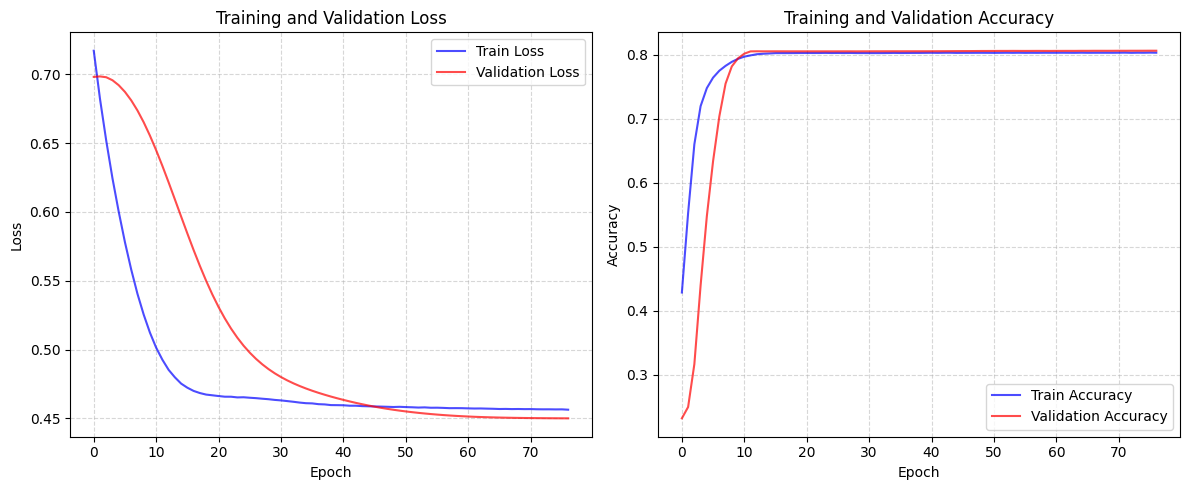

In [35]:
# ==================== ВИЗУАЛИЗАЦИЯ ПРОЦЕССА ОБУЧЕНИЯ ====================
plt.figure(figsize=(12, 5))

# График 1: Потери (Loss)
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss', color='blue', alpha=0.7)
plt.plot(val_loss_history, label='Validation Loss', color='red', alpha=0.7)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# График 2: Точность (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy', color='blue', alpha=0.7)
plt.plot(val_acc_history, label='Validation Accuracy', color='red', alpha=0.7)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Calculating ROC-AUC...


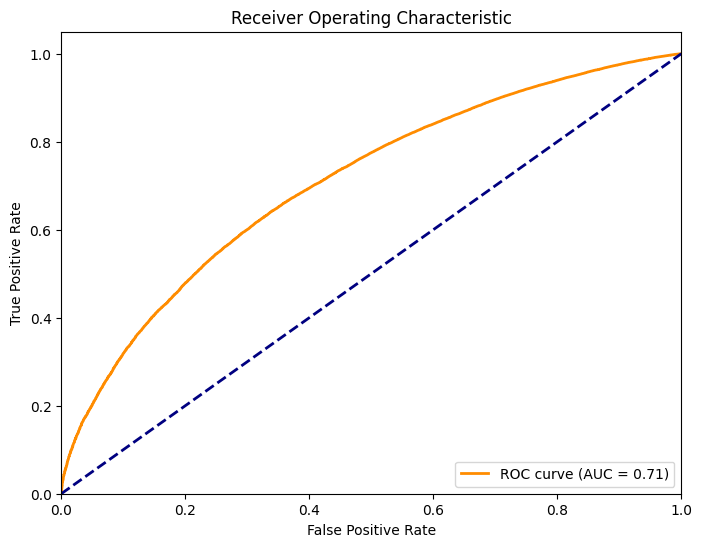

AUC-ROC score: 0.7068


In [37]:
# ==================== ROC-кривая и AUC ====================
from sklearn.metrics import roc_curve, roc_auc_score  # Добавляем импорт
import matplotlib.pyplot as plt

def plot_roc_curve(model, X, y):
    model.eval()
    with torch.no_grad():
        # Получаем вероятности для положительного класса
        y_probs = model(X).cpu().numpy().flatten()
        y_true = y.cpu().numpy().flatten()
        
        # Рассчитываем ROC-кривую
        fpr, tpr, thresholds = roc_curve(y_true, y_probs)
        roc_auc = roc_auc_score(y_true, y_probs)
        
        # Строим график
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        return roc_auc

# Строим ROC-кривую для модели с лучшими весами
best_model = NeuralNetwork(input_size=input_size).to(device)
checkpoint = torch.load(model_dir/'model_th_0.75.pth')  # Берем модель с любым порогом
best_model.load_state_dict(checkpoint['model_state_dict'])

print("\nCalculating ROC-AUC...")
auc_score = plot_roc_curve(best_model, X_test_tensor, y_test_tensor)
print(f"AUC-ROC score: {auc_score:.4f}")

# Предсказание для новых клиентов

In [39]:
import torch
import pandas as pd
from pathlib import Path
import joblib

# Загрузка модели PyTorch
model = torch.jit.load('saved_model/model_scripted.pt', map_location='cpu')
model.eval()                    # Переводим модель в режим оценки


def survived_person_predict(loan_amnt: float, int_rate: float, term: int, annual_inc: float,
                            Source_Verified: bool, Verified: bool, emp_length: float, 
                            dti: float, fico_range_low: float, open_acc: float, 
                            delinq_2yrs: float, mort_acc: float, total_acc: float, revol_util: float,
                            inq_last_6mths: float, OWN: bool, RENT: bool, OTHER: bool, 
                            purpose_home_improvement: bool,  purpose_debt_consolidation: bool, 
                            purpose_other: bool, pub_rec_bankruptcies: float): 
                                                 
    """
    Предсказывает вероятность и факт выдать кредит.
    
    Параметры:
    1 loan_amnt (Сумма кредита, $) Хорошо: 5k−20k | Плохо: >$30k (риск неплатёжеспособности)
    2 int_rate (Процентная ставка, %) Хорошо:<12% | Плохо:>18% (высокий риск, плохая кредитная история)
    3 term (Срок кредита, мес.) Хорошо: 36 (меньше времени для дефолта) | Плохо: 60 (долгий срок = больше рисков)
    4 annual_inc (Годовой доход, $) Хорошо: >50k | Плохо: <30k
    5 Source_Verified (Источник дохода подтвержден) Хорошо: 1 | Плохо: 0
    6 Verified (Доход подтвержден) Хорошо: 1 | Плохо: 0
    7 emp_length (Стаж работы, лет) Хорошо: ≥3 | Плохо: <1 (нестабильность)
    8 dti (Отношение долга к доходу) Хорошо: <20% | Плохо: >40% (критическая долговая нагрузка)
    9 fico_range_low (Кредитный скоринг FICO) Хорошо: ≥720 (надёжный заёмщик) | Плохо: <670 (высокий риск)
    10 open_acc (Открытые кредитные линии) Хорошо: 5-15 | Плохо: > 25 (риск перекредитования)
    11 delinq_2yrs (Просрочки за 2 года) Хорошо: 0 | Плохо: ≥1 (даже 1 просрочка увеличивает риск дефолта в 2-3 раза)
    12 mort_acc (Ипотечные счета) Хорошо: 1-3 (опыт управления долгом) | Плохо: 0 или >5 (высокая долговая нагрузка)
    13 total_acc (Всего кредитных счетов) Хорошо: 10-30 | Плохо: >30 (сложность управления)
    14 revol_util (% использования кредитного лимита) Хорошо: <30% | Плохо: >70% (финансовое напряжение)
    15 inq_last_6mths (Кредитные запросы) Хорошо: 0-1 | Плохо: ≥3 (отчаянный поиск кредитов)
    16 purpose_debt_consolidation (Цель: объединение долгов) Хорошо: 0 (другие цели) | Плохо: 1 (риск рефинансирования проблемных долгов)
    17 Категориальные признаки (bool) Хорошо: 1) OWN = 1 (владеет жильём), 2) purpose_home_improvement = 1 (цель - ремонт)
                                       Плохо: 1) RENT = 1 (аренда), 2) purpose_other = 1 (неясные цели), 3) pub_rec_bankruptcies ≥1 (банкротства в истории)
    
    """
    # Создаем DataFrame
    input_data = {
        "fico_range_low": [fico_range_low],
        "dti": [dti],
        "revol_util": [revol_util],
        "open_acc": [open_acc],
        "total_acc": [total_acc],
        "pub_rec_bankruptcies": [pub_rec_bankruptcies],
        "annual_inc": [annual_inc],
        "loan_amnt": [loan_amnt],
        "emp_length": [emp_length],
        "term": [term],
        "int_rate": [int_rate],
        "mort_acc": [mort_acc],
        "delinq_2yrs": [delinq_2yrs],
        "inq_last_6mths": [inq_last_6mths],
        "OTHER": [int(OTHER)],                          # Преобразуем bool в int
        "OWN": [int(OWN)],
        "RENT": [int(RENT)],
        "purpose_debt_consolidation": [int(purpose_debt_consolidation)],
        "purpose_home_improvement": [int(purpose_home_improvement)],
        "purpose_other": [int(purpose_other)],
        "Source_Verified": [int(Source_Verified)],
        "Verified": [int(Verified)]
    }

    input_df = pd.DataFrame(input_data)

    # Загрузка scaler
    scaler = joblib.load('saved_model/scaler.pkl')

    # Масштабирование данных
    X_scaled = scaler.transform(input_df)
    
    # Преобразование в тензор
    input_tensor = torch.FloatTensor(X_scaled)
    
    # Предсказание
    with torch.no_grad():
        prob = model(input_tensor).item()

    # Порог из названия файла модели (0.7)
    threshold = 0.7
    decision = "Кредит одобрен!" if prob > threshold else "Кредит не одобрен..."
    
    return {
        "decision": decision,
        "probability": round(prob, 4),
        "threshold": threshold
    }

# Создаем нового клиента
result = survived_person_predict(
    loan_amnt=10000.0,
    int_rate=5.0,
    term=60,
    annual_inc=70000.0,
    Source_Verified=True,
    Verified=True,
    emp_length=6.0,
    dti=0.5,
    fico_range_low=700.0,
    open_acc=2.0,
    delinq_2yrs=0.0,
    mort_acc=0.0,
    total_acc=2.0,
    revol_util=5.0,
    inq_last_6mths=1.0,
    OWN=False,
    RENT=True,
    OTHER=False,
    purpose_home_improvement=False,
    purpose_debt_consolidation=False,
    purpose_other=True,
    pub_rec_bankruptcies=0.0
)


print(result)

{'decision': 'Кредит не одобрен...', 'probability': 0.6982, 'threshold': 0.7}
